In [ ]:
import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
from collections import Counter
import math
import re
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [4]:
def extract_basic_features(seq):
    """
    Calcola feature direttamente dalla sequenza senza usare dizionari/scale.
    Restituisce un dizionario con feature e descrizione.
    """
    length = len(seq)  # lunghezza totale della sequenza
    counts = Counter(seq)
    
    # Percentuale di ogni amminoacido
    aa_percent = {f"%{aa}": counts[aa]/length for aa in counts}
    
    # Numero di residui acidi
    num_acidi = sum(1 for aa in seq if aa in "DE")
    
    # Numero di residui basici
    num_basici = sum(1 for aa in seq if aa in "KRH")
    
    # Numero di residui polari
    num_polari = sum(1 for aa in seq if aa in "NQSTY")
    
    # Numero di residui idrofobici
    num_idrofobi = sum(1 for aa in seq if aa in "AILMFWV")
    
    # Lunghezza del blocco più lungo di residui ripetuti consecutivi
    max_repeat = 1
    current_repeat = 1
    for i in range(1, length):
        if seq[i] == seq[i-1]:
            current_repeat += 1
            if current_repeat > max_repeat:
                max_repeat = current_repeat
        else:
            current_repeat = 1
    
    # Entropia della sequenza
    entropy = -sum((c/length) * math.log2(c/length) for c in counts.values())
    
    # Feature dei ponti disolfuro: C separati da 2-5 residui
    disulfide_matches = re.findall(r"C.{2,5}C", seq)
    num_disulfide_motifs = len(disulfide_matches)
    
    # Costruzione dizionario finale
    features = {
        "length": length,
        "num_acidi": num_acidi,
        "num_basici": num_basici,
        "num_polari": num_polari,
        "num_idrofobi": num_idrofobi,
        "max_repeat": max_repeat,
        "entropy": entropy,
        "num_disulfide_motifs": num_disulfide_motifs
    }
    
    # Aggiungo le percentuali di ogni residuo
    features.update(aa_percent)
    #print(features)
    return features


In [5]:
def init_matrix (window): #function that initialise the PSPM matrix, with pseudocounts. 
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I",
              "L","K","M","F","P","S","T","W","Y","V"]
    dict_mat = {}
    for i in aminoacids:
        dict_mat[i]= [1 for i in range(window)]
    return dict_mat

In [6]:
def compute_pswm (matrix,list_seq): #function that used the PSPM matrix and a list of sequences and computes the PSWM. Built as a dictionary of lists
    diz_swp = {'A':0.08, 'R':0.06, 'N':0.04, 'D':0.06, 'C':0.01, 'Q':0.04, 'E':0.07, 'G':0.07, 'H':0.02, 'I':0.06, 'L':0.10, 'K':0.06, 'M':0.02, 'F':0.04, 'P':0.05, 'S':0.07, 'T':0.05, 'W':0.01, 'Y':0.03, 'V':0.07} #frequency of residues from SwissProt
    for seq in list_seq:
        for index, res in enumerate(seq[:len(next(iter(matrix.values())))]):  # “For each sequence, go through its residues up to the PSWM length (e.g., 15),and for each residue, increment its count in the corresponding PSWM column.
            if res not in matrix:
                continue
            matrix[res][index] += 1

    
    div = int(len(list_seq))+20

    
    for key in matrix:
        matrix[key] = [np.log2(x/(div*diz_swp[key])) for x in matrix[key]]

    return matrix

In [7]:
def score_window(matrix, seq_window):
    """
    It's the function that calculates the position-specific score of an amino acid window with respect to the PSWM (Position-Specific Weight Matrix) —
    it's then used to slide across the entire sequence and find the point with the highest score, which most likely corresponds to the signal peptide region.
    """
    score = 0 # Initialize the total score to zero,this will accumulate the sum
    for pos in range(len(seq_window)):
        letter = seq_window[pos]
        if letter in matrix:
            # Add the corresponding weight from the PSWM for this amino acid
            # at the specific position to the running total score
            score += matrix[letter][pos]
    return score

In [8]:
def get_highest_pswm_scores(pswm, seqs, window_size=15):
    """
    Given a PSWM (Position-Specific Weight Matrix) and a list of sequences,
    compute the highest log-odds score for each sequence using a sliding window.
    Returns a list containing the highest PSWM score for each sequence.
    """

    scores = []

    for seq in seqs:
        # Skip sequences shorter than the window size
        if len(seq) < window_size:
            continue

        best_score = float('-inf')  # Start with very low value

        # Slide the window
        for i in range(len(seq) - window_size + 1):
            window = seq[i:i + window_size]
            score = 0.0

            for pos, aa in enumerate(window):
                if aa in pswm and pos < len(pswm[aa]):
                    score += pswm[aa][pos]

            # Track the best-scoring window
            if score > best_score:
                best_score = score

        scores.append(best_score)

    return scores


In [9]:
def proline_matrix_numpy(seqs, nterm_len=30):
    """
    Calcola, per ogni sequenza aminoacidica:
      - Il numero di residui 'P' (Proline) nei primi 30 amminoacidi
      - La densità di 'P' (cioè quante 'P' su quanti residui)
    Ritorna una matrice NumPy:
      righe   = sequenze
      colonne = [P_count_30, P_density_30]
    """
    
    # Lista dove salveremo i risultati
    results = []

    # Ciclo su ogni sequenza
    for seq in seqs:
        
        #  Prendiamo solo i primi 30 amminoacidi
        first_30 = seq[:nterm_len]

        #  Calcoliamo quanti 'P' (Proline) ci sono
        p_count = first_30.count('P')

        # Calcoliamo la lunghezza effettiva (può essere < 30)
        length = len(first_30)

        #  Calcoliamo la densità di Proline
        if length > 0:
            p_density = p_count / length
        else:
            p_density = 0

        # Creiamo un piccolo vettore [p_count, p_density]
        feature_vector = [p_count, p_density]

        #  Lo aggiungiamo alla lista dei risultati
        results.append(feature_vector)
    print(len(results))
    #  Convertiamo la lista in una matrice NumPy
    proline_matrix = np.array(results)

    #  Ritorniamo la matrice finale
    return proline_matrix

In [10]:
dataset = pd.read_csv("/home/anomalocaris/LB2_project_group_9/Data Preparation/training_file_all_seq.tsv",sep="\t")
dataset['positive/negative'] =np.where(dataset['SP cleavage']=='False', 0,1)
seqs=dataset["Sequence"].tolist()
print(len(seqs))

8020


In [11]:
#  PROLINE EXTRACTION

final_output = proline_matrix_numpy(seqs)
print(len(final_output))

8020
8020


In [12]:
#  SCORE EXTRACTION

matrix = init_matrix(15)              #initialise the PSWM with 1s and 15 colunmns
pswm = compute_pswm(matrix, seqs)     # build the PSWM
scores = get_highest_pswm_scores(pswm, seqs)   # get best score per sequence

scores=np.array(scores)
scores=scores.reshape(-1,1)

In [13]:
#  FEATURES EXTRACTION

data = [extract_basic_features(seq) for seq in seqs]
df_features = pd.DataFrame(data)
matrix_features = df_features.to_numpy()

In [17]:
# SP COLUMN EXTRACTION

vettore_anton_vivarelli_colonna = dataset['positive/negative'].to_numpy().reshape(-1, 1)

In [18]:
try_matrix = np.hstack([final_output,scores,matrix_features,vettore_anton_vivarelli_colonna])

final_matrix = np.nan_to_num(try_matrix, nan=0.0)

# Columns Description

| Index | Feature                  |
|-------|--------------------------|
| 0     | P_count_30               |
| 1     | P_density_30             |
| 2     | Score                    |
| 3     | length                   |
| 4     | num_acidi                |
| 5     | num_basici               |
| 6     | num_polari               |
| 7     | num_idrofobi             |
| 8     | max_repeat               |
| 9     | entropy                  |
| 10    | num_disulfide_motifs     |
| 11    | %M                       |
| 12    | %K                       |
| 13    | %A                       |
| 14    | %S                       |
| 15    | %V                       |
| 16    | %T                       |
| 17    | %L                       |
| 18    | %G                       |
| 19    | %P                       |
| 20    | %I                       |
| 21    | %R                       |
| 22    | %D                       |
| 23    | %N                       |
| 24    | %F                       |
| 25    | %E                       |
| 26    | %Y                       |
| 27    | %Q                       |
| 28    | %C                       |
| 29    | %H                       |
| 30    | %W                       |
| 31    | %U                       |
| 32    | %X                       |
| 33    | POSITIVE/NEGATIVE        |


In [ ]:
final_dataframe = pd.DataFrame(final_matrix)

In [20]:
final_dataframe

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,0.033333,7.504679,452.0,51.0,43.0,134.0,151.0,4.0,4.040580,...,0.042035,0.037611,0.053097,0.024336,0.013274,0.002212,0.006637,0.0,0.0,1.0
1,4.0,0.133333,7.335163,390.0,23.0,40.0,104.0,144.0,3.0,3.969724,...,0.020513,0.035897,0.017949,0.051282,0.012821,0.020513,0.012821,0.0,0.0,1.0
2,2.0,0.066667,7.363840,2586.0,299.0,340.0,556.0,1066.0,3.0,4.104638,...,0.036350,0.086234,0.031323,0.025909,0.013148,0.023975,0.006574,0.0,0.0,1.0
3,4.0,0.133333,6.888690,825.0,97.0,99.0,207.0,289.0,5.0,4.189001,...,0.044848,0.052121,0.032727,0.035152,0.020606,0.025455,0.019394,0.0,0.0,1.0
4,0.0,0.000000,9.597996,143.0,9.0,11.0,30.0,57.0,2.0,4.039273,...,0.041958,0.041958,0.027972,0.048951,0.076923,0.013986,0.006993,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,0.0,0.000000,6.117120,465.0,74.0,66.0,93.0,171.0,2.0,4.118710,...,0.038710,0.101075,0.021505,0.034409,0.025806,0.019355,0.006452,0.0,0.0,0.0
8016,1.0,0.033333,8.406212,142.0,34.0,15.0,33.0,34.0,4.0,4.067237,...,0.035211,0.169014,0.035211,0.049296,0.049296,0.021127,0.007042,0.0,0.0,0.0
8017,2.0,0.066667,7.176811,445.0,49.0,79.0,106.0,154.0,3.0,4.152206,...,0.065169,0.053933,0.040449,0.026966,0.011236,0.026966,0.024719,0.0,0.0,0.0
8018,1.0,0.033333,7.876031,335.0,60.0,70.0,72.0,115.0,3.0,3.890395,...,0.026866,0.119403,0.000000,0.065672,0.020896,0.011940,0.005970,0.0,0.0,0.0


### Variance Thresholding

This cell applies **Variance Thresholding**, a basic filter method that removes constant (zero-variance) features from the dataset.  
By keeping only features that vary across samples, it eliminates uninformative columns and simplifies the feature space before further analysis.


In [ ]:
# Variance thresholding (default threshold=0 removes only constant features)
feature_names = final_dataframe.drop(columns=33).columns
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(final_dataframe.drop(columns=33))
kept_mask_vt = vt.get_support()
kept_features_vt = feature_names[kept_mask_vt]

print("Kept features after VarianceThreshold:", kept_features_vt.tolist())
print("Shape before:", final_dataframe.drop(columns=33).shape, "after:", X_vt.shape)
print(kept_mask_vt)

Kept features after VarianceThreshold: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Shape before: (8020, 33) after: (8020, 33)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


### Correlation Filtering

This cell performs **correlation-based feature filtering** to remove highly correlated (redundant) features.  
It computes the absolute correlation matrix of the remaining features from the variance thresholding step, then drops one feature from each pair with a correlation above **0.90**.  
This helps reduce multicollinearity and keeps only independent, non-redundant features for the next analysis steps.


In [17]:
# Compute correlation on the (variance-filtered) features
X_corr = pd.DataFrame(X_vt, columns=kept_features_vt)
corr = X_corr.corr().abs()

# Upper triangle mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Drop columns above threshold
threshold = 0.90
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
X_uncorr = X_corr.drop(columns=to_drop)
kept_features_corr = X_uncorr.columns.values

print("Dropped (highly correlated):", to_drop)
print("Kept after correlation filtering:", kept_features_corr.tolist())
print("Shape before:", X_corr.shape, "after:", X_uncorr.shape)
print(X_corr)

Dropped (highly correlated): [1, 4, 5, 6, 7]
Kept after correlation filtering: [0, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Shape before: (8020, 33) after: (8020, 28)
       0         1         2       3      4      5      6       7    8   \
0     1.0  0.033333  7.504679   452.0   51.0   43.0  134.0   151.0  4.0   
1     4.0  0.133333  7.335163   390.0   23.0   40.0  104.0   144.0  3.0   
2     2.0  0.066667  7.363840  2586.0  299.0  340.0  556.0  1066.0  3.0   
3     4.0  0.133333  6.888690   825.0   97.0   99.0  207.0   289.0  5.0   
4     0.0  0.000000  9.597996   143.0    9.0   11.0   30.0    57.0  2.0   
...   ...       ...       ...     ...    ...    ...    ...     ...  ...   
8015  0.0  0.000000  6.117120   465.0   74.0   66.0   93.0   171.0  2.0   
8016  1.0  0.033333  8.406212   142.0   34.0   15.0   33.0    34.0  4.0   
8017  2.0  0.066667  7.176811   445.0   49.0   79.0  106.0   154.0  3.0   
8018  1.0  0.033333 

### Chi-Squared Feature Selection

This cell applies the **Chi-squared (χ²) test** to evaluate the relationship between each feature and the target variable.  
After scaling all features to the [0, 1] range (required for χ²), it computes a score and p-value for each feature, indicating how strongly it is associated with the target.  
Features with higher χ² scores are more informative for classification. A horizontal bar plot visualizes the feature importance based on these scores.


Chi-squared scores
    feature  chi2_score       p_value
23       28   54.200237  1.810650e-13
20       25   10.033944  1.536816e-03
5        10    6.949883  8.382471e-03
26       31    5.858037  1.550608e-02
13       18    5.559602  1.837960e-02
7        12    5.556038  1.841705e-02
21       26    3.613458  5.731382e-02
0         0    2.657201  1.030820e-01
25       30    2.568595  1.090045e-01
11       16    2.389746  1.221334e-01
16       21    2.065672  1.506485e-01
9        14    2.060313  1.511791e-01
10       15    1.957328  1.617994e-01
2         3    1.529932  2.161227e-01
8        13    1.498576  2.208905e-01
15       20    1.290410  2.559724e-01
3         8    1.065915  3.018701e-01
17       22    0.879344  3.483815e-01
27       32    0.699051  4.031027e-01
24       29    0.450942  5.018879e-01
19       24    0.444606  5.049079e-01
22       27    0.403451  5.253124e-01
18       23    0.265263  6.065273e-01
14       19    0.176988  6.739745e-01
6        11    0.112591  7.3721

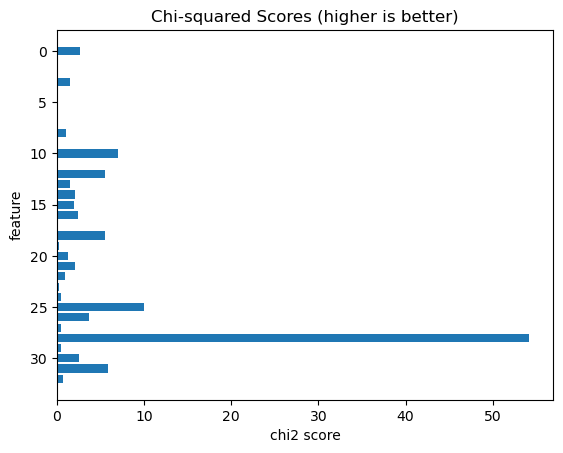

In [18]:
# Scale to [0, 1] for chi2
scaler = MinMaxScaler()
X_pos = scaler.fit_transform(X_uncorr)
y = final_dataframe[33]

chi2_scores, chi2_p = chi2(X_pos, y)
chi2_df = pd.DataFrame({
    "feature": kept_features_corr,
    "chi2_score": chi2_scores,
    "p_value": chi2_p
}).sort_values("chi2_score", ascending=False)

print("Chi-squared scores")
print(chi2_df)
# Plot
plt.figure()
plt.barh(chi2_df["feature"], chi2_df["chi2_score"])
plt.title("Chi-squared Scores (higher is better)")
plt.xlabel("chi2 score")
plt.ylabel("feature")
plt.gca().invert_yaxis()
plt.show()

### Mutual Information Feature Selection

This cell uses **Mutual Information (MI)** to measure how much information each feature provides about the target variable.  
Unlike the Chi-squared test, MI can capture both linear and non-linear dependencies.  
Higher mutual information values indicate features that are more relevant for predicting the target.  
A bar plot is displayed to visualize the importance of each feature based on MI scores.

Mutual Information scores


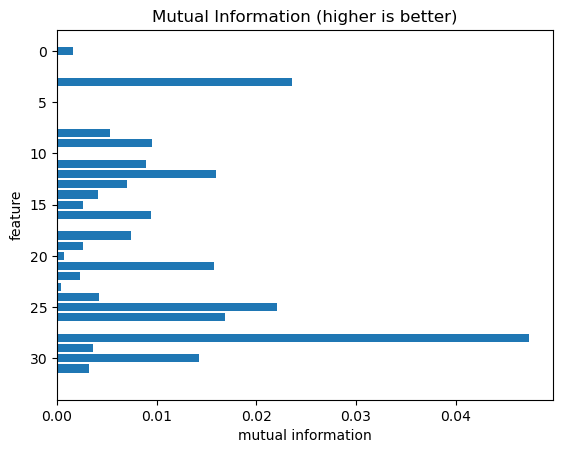

In [19]:
mi = mutual_info_classif(X_uncorr.values, y, random_state=42)
mi_df = pd.DataFrame({"feature": kept_features_corr, "mutual_info": mi}).sort_values("mutual_info", ascending=False)

print("Mutual Information scores")
# Plot
plt.figure()
plt.barh(mi_df["feature"], mi_df["mutual_info"])
plt.title("Mutual Information (higher is better)")
plt.xlabel("mutual information")
plt.ylabel("feature")
plt.gca().invert_yaxis()
plt.show()

### Cross-Validation Accuracy Comparison

This cell evaluates how different feature selection steps affect model performance using **5-fold cross-validation** with a Logistic Regression classifier.  
It compares three scenarios:  
1. Using all original features,  
2. Using features after variance and correlation filtering,  
3. Using only the top 10 features ranked by Mutual Information.  

The mean and standard deviation of cross-validation accuracy are printed, allowing assessment of how much feature reduction impacts predictive performance.


In [20]:
def cv_score(Xmat, y, cv=5):
    clf = LogisticRegression(max_iter=1000)
    scores = cross_val_score(clf, Xmat, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42))
    return scores.mean(), scores.std()

# All features
mean_all, std_all = cv_score(final_dataframe.drop(columns=33).values, y)

# After variance + correlation filtering
mean_uncorr, std_uncorr = cv_score(X_uncorr.values, y)

# Top-k by MI
k = min(10, X_uncorr.shape[1])
topk = mi_df.head(k)["feature"].values
mean_topk, std_topk = cv_score(X_uncorr[topk].values, y)

print(f"CV accuracy (All): {mean_all:.3f} ± {std_all:.3f}")
print(f"CV accuracy (Variance+Correlation filtered): {mean_uncorr:.3f} ± {std_uncorr:.3f}")
print(f"CV accuracy (Top-{k} by MI): {mean_topk:.3f} ± {std_topk:.3f}")

/home/anomalocaris/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anomalocaris/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

CV accuracy (All): 0.897 ± 0.001
CV accuracy (Variance+Correlation filtered): 0.895 ± 0.002
CV accuracy (Top-10 by MI): 0.891 ± 0.001


### Recursive Feature Elimination (RFE) (Wrapper Method)

This cell performs **Recursive Feature Elimination (RFE)** using Logistic Regression as the estimator.  
RFE iteratively trains the model, removes the least important features based on model coefficients, and repeats until only the specified number (here, 10) remains.  
It outputs the top selected features and a ranked list showing the relative importance of all features.  
This helps identify the most influential variables for the classification task.


In [ ]:


estimator = LogisticRegression(max_iter=2000, solver="liblinear")
rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
rfe.fit(final_dataframe.drop(columns=33), y)

selected_rfe = feature_names[rfe.support_]
ranking_rfe = pd.DataFrame({"feature": feature_names, "rank": rfe.ranking_}).sort_values("rank")
print("Selected by RFE:", selected_rfe.tolist())
print("RFE ranking")
print(ranking_rfe.head(15))

Selected by RFE: [12, 14, 16, 18, 20, 21, 25, 26, 27, 28]
RFE ranking
    feature  rank
16       16     1
20       20     1
14       14     1
12       12     1
21       21     1
25       25     1
18       18     1
27       27     1
28       28     1
26       26     1
15       15     2
13       13     3
30       30     4
29       29     5
9         9     6


### Model Evaluation with RFE-Selected Features

This cell compares the classification performance between using **all features** and using only the **10 features selected by RFE**.  
It computes the mean accuracy using 5-fold stratified cross-validation with Logistic Regression.  
The results show whether the reduced feature set maintains similar predictive performance compared to the full feature set.

In [22]:
def cv_acc(X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(LogisticRegression(max_iter=2000, solver="liblinear"), X, y, cv=cv).mean()

acc_all = cv_acc(final_dataframe.drop(columns=33).values, y)
acc_rfe = cv_acc(final_dataframe[selected_rfe].values, y)

print(f"Accuracy with all features: {acc_all:.3f}")
print(f"Accuracy with RFE-selected features (k=10): {acc_rfe:.3f}")

Accuracy with all features: 0.897
Accuracy with RFE-selected features (k=10): 0.892


### Recursive Feature Elimination with Cross-Validation (RFECV)

This cell extends RFE by using **cross-validation** to automatically determine the optimal number of features.  
RFECV repeatedly fits a Logistic Regression model, eliminating the least important features at each step while tracking validation accuracy.  
It outputs the number of selected features, the best cross-validation score, and a performance curve showing accuracy versus the number of retained features.  
This method helps identify the smallest subset of features that achieves the best model performance.

RFECV selected k = 33
Selected features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Best accuracy: 0.897


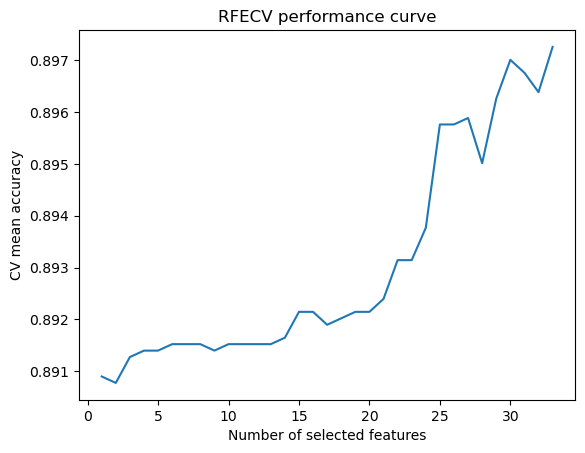

In [23]:
rfecv = RFECV(estimator=LogisticRegression(max_iter=2000, solver="liblinear"),
              step=1, cv=StratifiedKFold(5, shuffle=True, random_state=42))
rfecv.fit(final_dataframe.drop(columns=33), y)

selected_rfecv = feature_names[rfecv.support_]
print("RFECV selected k =", rfecv.n_features_)
print("Selected features:", selected_rfecv.tolist())
print(f"Best accuracy: {rfecv.cv_results_['mean_test_score'][rfecv.n_features_-1]:.3f}")

# Plot CV scores vs number of features
plt.figure()
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of selected features")
plt.ylabel("CV mean accuracy")
plt.title("RFECV performance curve")
plt.show()

### Sequential Feature Selection (Forward & Backward)

This cell implements the wrapper method **forward selection**. Starting with no features,adding features one at a time. At each step, add the feature that improves model performance the most (e.g., accuracy, AUC). Stop when performance no longer improves. It also implements the wrapper method **backward elimination** starting with all features.Then by removing the least important feature iteratively. It is based on decrease in performance.

In [31]:

# Assuming column 33 is the target (adjust if needed)
y = final_dataframe.iloc[:, -1]        # last column as target
X = final_dataframe.iloc[:, :-1]       # all columns except last
feature_names = X.columns

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", probability=False))
])

# Forward selection: start empty, add features
sfs_forward = SequentialFeatureSelector(
    pipeline, n_features_to_select=10, direction="forward",
    scoring="accuracy", cv=StratifiedKFold(5, shuffle=True, random_state=42), n_jobs=-1
)
sfs_forward.fit(X, y)
selected_forward = feature_names[sfs_forward.get_support()]
print("Forward SFS selected:", selected_forward.tolist())

# Backward selection: start full, remove features
sfs_backward = SequentialFeatureSelector(
    pipeline, n_features_to_select=10, direction="backward",
    scoring="accuracy", cv=StratifiedKFold(5, shuffle=True, random_state=42), n_jobs=-1
)
sfs_backward.fit(X, y)
selected_backward = feature_names[sfs_backward.get_support()]
print("Backward SFS selected:", selected_backward.tolist())

Forward SFS selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Backward SFS selected: [0, 12, 14, 20, 21, 24, 25, 27, 28, 29]


### Performance comparison

Cell displaying the performance comparison between the wrapper methods

In [32]:
def cv_acc_pipe(features):
    Xsel = final_dataframe[features].values
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, Xsel, y, cv=cv)
    return scores.mean()

acc_forward = cv_acc_pipe(selected_forward)
acc_backward = cv_acc_pipe(selected_backward)

print(f"Accuracy (all features) with SVM pipeline: {cv_acc_pipe(feature_names):.3f}")
print(f"Accuracy (Forward SFS, k=10): {acc_forward:.3f}")
print(f"Accuracy (Backward SFS, k=10): {acc_backward:.3f}")

Accuracy (all features) with SVM pipeline: 0.904
Accuracy (Forward SFS, k=10): 0.891
Accuracy (Backward SFS, k=10): 0.900


### Reproducibility and Display Settings

This cell ensures **reproducibility** and improves **output readability**.  
A fixed random seed (`random_state=42`) guarantees consistent results across runs, while NumPy and Pandas display settings make printed arrays and DataFrames easier to read by widening the output and showing more columns without scientific notation.


In [ ]:
# Reproducibility & display
rng = np.random.RandomState(42)
np.set_printoptions(suppress=True, linewidth=120)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 100)

### Train, Validation, and Test Split

This cell separates the dataset into **training**, **validation**, and **test** sets.  
The training set (60%) is used to fit models, the validation set (20%) to tune hyperparameters, and the test set (20%) to evaluate final performance.  
This ensures a fair and unbiased assessment of the model’s generalization ability.

In [25]:
X = final_dataframe.drop(columns=33)
y = final_dataframe[33]
feature_names = X.columns


X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (4812, 33)
Validation set shape: (1604, 33)
Test set shape: (1604, 33)


### Baseline SVM with Manual Grid Search

This cell builds a **baseline Support Vector Machine (SVM)** model using an RBF kernel and standardized features.  
A small **manual grid search** over hyperparameters `C` (regularization strength) and `gamma` (kernel width) is performed.  
Each combination is trained on the **training set** and evaluated on the **validation set** to find the parameters yielding the highest accuracy.  
This serves as a performance baseline before applying feature selection methods.

In [26]:
# We'll use a simple StandardScaler + RBF SVM pipeline
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

# Minimal manual grid
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

best_score_base = -np.inf
best_params_base = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(X_train, y_train)                 # fit on TRAIN
        val_acc = pipe.score(X_val, y_val)         # evaluate on VALIDATION
        if val_acc > best_score_base:
            best_score_base = val_acc
            best_params_base = {"C": C, "gamma": gamma}

print("Baseline SVM (all features) — best validation accuracy: "
      f"{best_score_base:.3f} with params {best_params_base}")

Baseline SVM (all features) — best validation accuracy: 0.916 with params {'C': 10.0, 'gamma': 0.01}


### Random Forest Feature Importance (Gini)

This cell trains a **Random Forest classifier** on the training set to estimate **feature importance** using the Gini impurity measure.  
Each feature’s importance reflects how much it contributes to reducing classification error across all trees.  
The top 10 most important features are printed, and a horizontal bar chart visualizes the top 20.  
These importances will later guide the selection of the most relevant subset of features for the SVM model.

Top 10 features by Gini importance:
   feature  importance
0       28    0.112444
1       16    0.047712
2       12    0.044077
3        5    0.043062
4       11    0.042097
5       21    0.041260
6       18    0.040436
7       25    0.039684
8       30    0.038381
9        9    0.038120


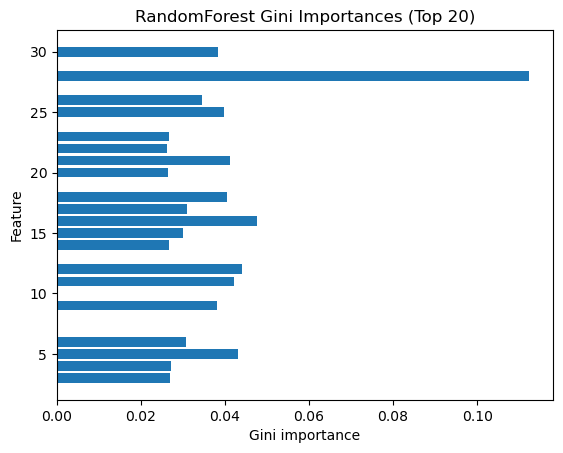

In [27]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # fit only on TRAIN

gini_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]
print("Top 10 features by Gini importance:")
print(gini_df.head(10))

# Plot top 20
plt.figure()
plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("RandomForest Gini Importances (Top 20)")
plt.show()

### Accuracy vs. Number of Selected Features (Validation Curve)

This cell evaluates how the **number of top features** (based on Random Forest Gini importance) affects SVM performance.  
For each `k`, it trains an SVM using only the top-k features and computes validation accuracy with the best baseline hyperparameters.  
The resulting curve shows whether adding more features improves or saturates accuracy, helping determine the **optimal number of informative features** to retain.

Best k on validation (using baseline best params): k=19, val_acc=0.915


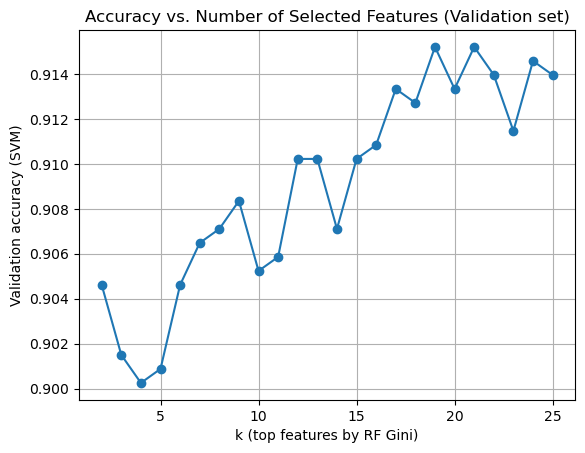

In [28]:
def accuracy_on_subset(C, gamma, subset_features):
    # Se subset_features contiene i NOMI delle colonne
    idx = [X_train.columns.get_loc(f) for f in subset_features]  # ottieni indici numerici
    Xtr = X_train.values[:, idx]  # converti a NumPy e prendi solo le colonne desiderate
    Xva = X_val.values[:, idx]
    
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train sul TRAIN
    return pipe.score(Xva, y_val)  # accuracy su VALIDATION

# We'll sweep k and, for each k, re-evaluate the best baseline SVM params on the reduced feature set
ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
curve = []

for k in ks:
    subset = gini_df["feature"].head(k).tolist()
    acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
    curve.append(acc_k)

best_k_idx = int(np.argmax(curve))
best_k = ks[best_k_idx]
print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

plt.figure()
plt.plot(ks, curve, marker="o")
plt.xlabel("k (top features by RF Gini)")
plt.ylabel("Validation accuracy (SVM)")
plt.title("Accuracy vs. Number of Selected Features (Validation set)")
plt.grid(True)
plt.show()

### Final Model Training and Evaluation (Top-k Features)

This cell retrains and evaluates the SVM model using only the **top-k most important features** identified from the validation curve.  
After selecting those features, it performs another **grid search** over `C` and `gamma` to re-optimize the SVM specifically for this reduced feature set.  
The model’s accuracy is then evaluated on both the **validation** and **test sets**, and results are compared with the baseline model that used all features.  
This step confirms whether feature selection maintains or improves performance while reducing dimensionality.


In [29]:
# Use the best k from the validation curve
best_subset = gini_df["feature"].head(best_k).tolist()
# Ottieni gli indici numerici delle colonne corrispondenti
if isinstance(best_subset[0], str):
    idx = [X_train.columns.get_loc(f) for f in best_subset]  # se hai NOMI
else:
    idx = best_subset  # se hai già INDICI numerici

# Converti i DataFrame in array NumPy una volta
X_train_np = X_train.values
X_val_np   = X_val.values
X_test_np  = X_test.values

# Estrai solo le colonne selezionate
Xtr_sel = X_train_np[:, idx]
Xva_sel = X_val_np[:, idx]
Xte_sel = X_test_np[:, idx]


# Manual grid search again but now restricted to the selected features
best_score_sel = -np.inf
best_params_sel = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(Xtr_sel, y_train)      # train on TRAIN
        val_acc = pipe.score(Xva_sel, y_val)  # validate on VAL
        if val_acc > best_score_sel:
            best_score_sel = val_acc
            best_params_sel = {"C": C, "gamma": gamma}

# Train final model on TRAIN+VAL with best params (optional) or just TRAIN; here we keep TRAIN only as per your outline
final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
final_pipe.fit(Xtr_sel, y_train)
test_acc = final_pipe.score(Xte_sel, y_test)

print("Selected features (best k):", best_subset)
print("Best validation accuracy on selected features:", f"{best_score_sel:.3f}", "with", best_params_sel)
print("Test accuracy (selected features, tuned on val):", f"{test_acc:.3f}")

# For comparison: test accuracy with all features using baseline best params
baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
baseline_pipe.fit(X_train, y_train)
test_acc_all = baseline_pipe.score(X_test, y_test)
print("Test accuracy (all features, baseline tuned on val):", f"{test_acc_all:.3f}")

Selected features (best k): [28, 16, 12, 5, 11, 21, 18, 25, 30, 9, 26, 17, 6, 15, 4, 3, 14, 23, 20]
Best validation accuracy on selected features: 0.916 with {'C': 100.0, 'gamma': 0.01}
Test accuracy (selected features, tuned on val): 0.913
Test accuracy (all features, baseline tuned on val): 0.920
